##### Implement a Linear Classifier of form f = Wx, using SVM loss function and weights updated by stochastic gradient descent

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys, os
import skimage.io as io
from skimage.transform import resize
sys.path.append('../')
import nn.linear_classifier as LC
import helpers.histogram_classifier as hc
from imp import reload
import time

In [2]:
from IPython.core.display import HTML
css = open('styles/table-style.css').read() #+ open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [3]:
SIZE = 64

In [95]:
def get_sub_indices(total_length, class_list, num_train, per_class):
    all_indices = np.arange(total_length)
    train_indices = []
    test_indices = []
    for i, c in enumerate(class_list):
        train_indices.append(all_indices[i * per_class:(i * per_class) + num_train])
        test_indices.append(all_indices[(i * per_class) + num_train:(i + 1) * per_class])
    train_indices = np.array(train_indices)
    train_indices = train_indices.reshape((train_indices.shape[0] * train_indices.shape[1],))
    test_indices = np.array(test_indices)
    test_indices = test_indices.reshape((test_indices.shape[0] * test_indices.shape[1],))
    return train_indices, test_indices

In [4]:
classes = pd.read_csv('../data/food-101/meta/top_classes.csv', index_col=0)
class_list = list(classes['class'].unique())

image_names = {}
for c in class_list:
    image_names[c] = np.array(classes[classes['class'] == c]['name'])

In [5]:
# Load the images, and rescale to smaller size
X = []
y = []
for i, c in enumerate(class_list):
    for im_name in image_names[c]:
        im = io.imread(os.path.join("../data/food-101/top_classes/", c, "", im_name))
        im = resize(im, (SIZE, SIZE, SIZE, 3))
        X.append(im)
        y.append(i)

In [6]:
# Convert X and y to numpy arrays for ease of use
X = np.array(X)
y = np.array(y)
print("X has shape: {}".format(X.shape))
print("y has shape: {}".format(y.shape))

X has shape: (12000, 64, 64, 3)
y has shape: (12000,)


In [87]:
n_train = int(np.floor(0.85 * 1000))
train_indices, test_indices = get_sub_indices(X.shape[0], class_list, n_train, 1000)
X_train = X[train_indices]
y_train = y[train_indices]
X_test = X[test_indices]
y_test = y[test_indices]
print("X_train has shape: {}".format(X_train.shape))
print("y_train has shape: {}".format(y_train.shape))
print("X_test has shape: {}".format(X_test.shape))
print("y_test has shape: {}".format(y_test.shape))

X_train has shape: (10200, 64, 64, 3)
y_train has shape: (10200,)
X_test has shape: (1800, 64, 64, 3)
y_test has shape: (1800,)


In [88]:
# Reshape the X data
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))

print("X_train has shape: {}".format(X_train.shape))
print("X_test has shape: {}".format(X_test.shape))

X_train has shape: (10200, 12288)
X_test has shape: (1800, 12288)


In [89]:
# Subtract the mean image
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_test -= mean_image

In [90]:
# Append bias dimension of ones to simplify the optimization procedure
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

print("X_train has shape: {}".format(X_train.shape))
print("X_test has shape: {}".format(X_test.shape))

X_train has shape: (10200, 12289)
X_test has shape: (1800, 12289)


In [111]:
%%time
# Do some cross validation for learning rate and regularization weight
learning_rates = [1e-5, 1e-4]
reg_weights = [0.001, 0]

results = {}
best_score = -1   # The highest validation accuracy that we have seen so far.
best_params = (0,0)

for l in learning_rates:
    for r in reg_weights:
        #Get some training and validation data
            n_sub_train = int(np.floor(0.85 * n_train))
            train_mask, test_mask = get_sub_indices(X_train.shape[0], class_list, n_sub_train, n_train)
            X_t = X_train[train_mask]
            X_val = X_train[test_mask]
            y_t = y_train[train_mask]
            y_val = y_train[test_mask]
            svm = LC.LinearSVM()
            losses = svm.fit(X_t, y_t, learning_rate=l, lam=r, num_iterations=1500)
            predictions = svm.predict(X_val)
            score = np.mean(predictions == y_val)
            results[(l, r)] = score
            if score > best_score:
                best_score = score
                best_params = (l, r)

print("Best result: {}".format(best_score))
print("Learning rate: {}, Regularization factor: {}".format(best_params[0], best_params[1]))

Best result: 0.240234375
Learning rate: 0.0001, Regularization factor: 0
CPU times: user 3min 23s, sys: 29.9 s, total: 3min 53s
Wall time: 2min 1s


In [112]:
best_params

(0.0001, 0)

In [113]:
svm = LC.LinearSVM()

In [117]:
start = time.time()
losses = svm.fit(X_train, y_train, learning_rate = best_params[0], lam = best_params[1], num_iterations=10000, verbose=True)
end = time.time()
print ('That took %fs' % (end - start))

Iteration 0 of 10,000: 6.307
Iteration 100 of 10,000: 6.681
Iteration 200 of 10,000: 6.929
Iteration 300 of 10,000: 6.533
Iteration 400 of 10,000: 6.564
Iteration 500 of 10,000: 6.729
Iteration 600 of 10,000: 6.240
Iteration 700 of 10,000: 6.827
Iteration 800 of 10,000: 6.658
Iteration 900 of 10,000: 6.787
Iteration 1,000 of 10,000: 5.878
Iteration 1,100 of 10,000: 6.504
Iteration 1,200 of 10,000: 6.308
Iteration 1,300 of 10,000: 5.953
Iteration 1,400 of 10,000: 5.952
Iteration 1,500 of 10,000: 6.165
Iteration 1,600 of 10,000: 6.765
Iteration 1,700 of 10,000: 6.090
Iteration 1,800 of 10,000: 6.550
Iteration 1,900 of 10,000: 5.675
Iteration 2,000 of 10,000: 5.835
Iteration 2,100 of 10,000: 6.252
Iteration 2,200 of 10,000: 5.759
Iteration 2,300 of 10,000: 5.960
Iteration 2,400 of 10,000: 5.626
Iteration 2,500 of 10,000: 5.774
Iteration 2,600 of 10,000: 5.591
Iteration 2,700 of 10,000: 6.618
Iteration 2,800 of 10,000: 6.652
Iteration 2,900 of 10,000: 6.154
Iteration 3,000 of 10,000: 6.419

In [118]:
plt.style.use('seaborn-pastel')

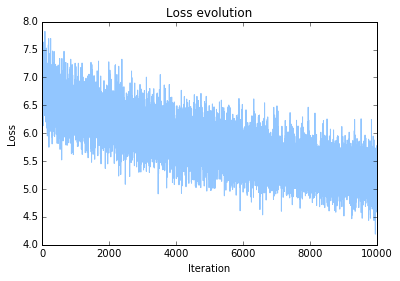

In [119]:
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Loss evolution")
plt.show()

In [120]:
predictions = svm.predict(X_test)

In [121]:
def get_class(x):
    return class_list[x]

get_class = np.vectorize(get_class)

In [122]:
overall, metrics, confusion = hc.get_metrics(get_class(y_test), get_class(predictions), class_list)

In [123]:
overall

,Accuracy,F1,Precision,Recall
Results,0.242,0.232,0.23,0.242


In [124]:
metrics

,Precision,Recall,F1-Score,Support
pork_chop,0.20,0.28,0.24,150.0
lasagna,0.21,0.17,0.19,150.0
french_toast,0.14,0.13,0.13,150.0
guacamole,0.37,0.47,0.41,150.0
apple_pie,0.19,0.13,0.15,150.0
cheesecake,0.22,0.19,0.21,150.0
hamburger,0.16,0.11,0.13,150.0
fried_rice,0.24,0.27,0.25,150.0
carrot_cake,0.17,0.13,0.15,150.0
chocolate_cake,0.32,0.44,0.37,150.0


In [125]:
confusion

,pork_chop,lasagna,french_toast,guacamole,apple_pie,cheesecake,hamburger,fried_rice,carrot_cake,chocolate_cake,steak,pizza
pork_chop,42,10,6,8,5,10,9,10,8,11,23,8
lasagna,18,26,16,9,8,7,12,18,7,7,6,16
french_toast,19,21,19,6,10,18,3,14,13,11,7,9
guacamole,8,4,9,70,4,3,12,19,6,7,3,5
apple_pie,13,9,12,9,19,15,4,17,14,11,7,20
cheesecake,13,8,8,9,9,29,5,6,12,23,14,14
hamburger,18,7,18,14,9,2,17,12,11,15,7,20
fried_rice,8,9,11,21,15,7,8,40,3,7,4,17
carrot_cake,13,5,11,15,9,12,15,9,20,19,11,11
chocolate_cake,15,1,8,12,1,15,5,1,8,66,18,0
